# **TP Analyse de sentiments (NLP)**

Le but de ce TP est de découvrir le Natural Language Processing (NLP) avec un exemple classique, celui de l'analyse de sentiments. Le problème consiste en le fait d'entrainer un modèle afin qu'il soit capable de déterminer si un commentaire (avis Amazon, tweet...) est positif, négatif ou neutre.

On va introduire ici les principales méthodes utilisées en NLP (nettoyage du texte, puis transformation du texte en vecteur), ainsi que l'implémentation d'algorithmes de **machine learning avec scikit-learn (arbre de décision, random forests)**, puis des algorithmes de **deep learning avec tensorflow (réseaux de neurones notamment)**.

# 0) Récupération des données

On va d'abord récupérer un dataset sous Python grâce à la bibliothèque pandas. N'hésitez pas à regarder la documentation de pandas et à vous familiariser avec cette bibliothèque, qui est très utilisée en IA et notamment en data science.

Le dataset que j'ai utilisé peut être récupéré sur ce lien : https://www.kaggle.com/crowdflower/twitter-airline-sentiment (vous pouvez en prendre un autre si vous voulez, mais pour l'instant je vous propose de prendre le même que moi). Ensuite renommez-le en "data" et placez le dans le même dossier que ce fichier.

In [1]:
import pandas as pd

In [2]:
# On charge les données sous forme de dataframe pandas, n'hésitez pas à vous renseigner sur ce que c'est
df = pd.read_csv("data.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# Visualisation de la liste des colonnes du dataframe
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [4]:
# Visualisation
print(df['text'][0])
print(df['airline_sentiment'][0])

@VirginAmerica What @dhepburn said.
neutral


**A faire** : on ne va garder que les colonnes 'text' et 'airline_sentiment' (les autres ne sont a priori pas vraiment utiles pour prédire le sentiment). Essayez de supprimer toutes les autres colonnes du dataframe

In [5]:
df = df.drop(columns=['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'])
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


**A faire** : la colonne 'airline_sentiment' contient les valeurs 'positive', 'neutral', et 'negative'. Essayez d'essayer de les changer en respectivement 1, 0 et -1

En effet, cette colonne constitue les labels de nos données d'entrainement, et on a besoin de les transformer en valeurs numériques

In [6]:
def encode_sentiment(sentiment):
    if sentiment == 'neutral':
        return 0
    elif sentiment == 'positive':
        return 1
    else:
        return -1
    
df['airline_sentiment'] = df['airline_sentiment'].apply(encode_sentiment)
df.head()

,airline_sentiment,text
0,0,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...
2,0,@VirginAmerica I didn't today... Must mean I n...
3,-1,@VirginAmerica it's really aggressive to blast...
4,-1,@VirginAmerica and it's a really big bad thing...


# I) Preprocessing du texte

Le but de cette section est de nettoyer le texte du jeu de données. On peut par exemple supprimer les majuscules (afin que notre futur modèle ne considère pas les mots "voiture" et "Voiture" comme étant différents). On peut aussi supprimer les liens, les emojis, les accents... tout ce que vous voulez !

Vous êtes totalement libres à ce niveau là, essayez de traiter le texte de la manière la plus pertinente selon vous.

**A faire** : Ecrivez une fonction qui nettoie une chaine de caractères représentant un commentaire. On l'appliquera par la suite au dataframe entier.
Bien sûr n'hésitez pas à écrire des fonctions intermédiaires

In [8]:
import re 
import string
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')

def preprocess_text(text):
    """
    Cette fonction prend en argument une chaine de caractères text 
    (par exemple : text="that was a very nice flight ! :D"),
    nettoie le texte (par exemple supprime les emojis), et renvoie la variable text
    """
    text = text.lower()
    
    # On retire les mentions et les hashtag
    text = re.sub("(@|#)[a-zA-Z0-9]*(\\s|$)", " ", text)
    
    # On retire la ponctuation
    text = "".join([char for char in text if char not in string.punctuation])
    
    # On retire les chiffres
    text = re.sub("[0-9]", "", text)
    
    # On tokenize (càd on transforme la chaine de caractères "un bateau bleu" en une liste ['un', 'bateau', 'bleu'])
    words = word_tokenize(text)
    
    # On retire les 'stopwords' (les mots qui reviennent le plus souvent, comme "me", "my"...)
    filtered_words = [word for word in words if word not in stop_words]
    
    # On lemmatise (on ramène les mots à leur racine, par exemple on transforme "universally" en "univers")
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in filtered_words]
    
    # On transforme la liste en chaine de caractères
    res = ' '.join(stemmed)
    
    return res

text = df['text'][3]
print("Text : ", text)
print("Text processed : ", preprocess_text(text))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Text :  @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
Text processed :  realli aggress blast obnoxi entertain guest face amp littl recours


**A faire** : A présent, on peut appliquer cette fonction à toutes les lignes du dataframe

In [9]:
df['text_processed'] = df['text'].apply(preprocess_text)
df.head()

,airline_sentiment,text,text_processed
0,0,@VirginAmerica What @dhepburn said.,said
1,1,@VirginAmerica plus you've added commercials t...,plu youv ad commerci experi tacki
2,0,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take anoth trip
3,-1,@VirginAmerica it's really aggressive to blast...,realli aggress blast obnoxi entertain guest fa...
4,-1,@VirginAmerica and it's a really big bad thing...,realli big bad thing


# II) Représentation des données

**Cette section consiste à transformer le texte en vecteurs**, afin d'utiliser ensuite ces vecteurs pour notre modèle.
En effet, un modèle ne peut pas prendre en entrée une chaine de caractères, on doit obligatoirement lui fournir un vecteur en entrée. Il faut donc trouver le moyen de transformer nos messages en vecteurs, et c'est ce qu'on appelle la représentation de données.

Pour la représentation de données, vous avez le choix : Bag-of-words, TF-IDF, Doc2Vec, ... (je vais détailler leur fonctionnement ci-dessous)

## 1) Bag-of-words 

Bag-of-words est une technique de représentation de données très élémentaire et qui peut parfois être efficace. Elle consiste à transformer chaque phrase en un vecteur de 0 et de 1, avec pour seule règle de mettre un 1 lorsqu'un certain mot est présent.

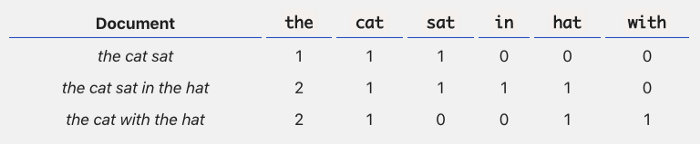

Vous pouvez voir une illustration sur la figure ci-dessus : chaque phrase est alors transformée en un vecteur ("the cat sat" --> [1, 1, 1, 0, 0, 0])

Comme vous pouvez le deviner, cette méthode présente des inconvénients car le vecteur résultant ne prend pas du tout en compte de l'ordre des mots dans la phrase, qui a évidemment une importance majeure. Pour en tenir compte, il faudra se tourner vers des méthodes de représentation de données comme Word2Vec ou Doc2Vec qui ont un fonctionnement plus complexe.

En ce qui concerne l'implémentation, on pourrait programmer le bag of words à la main mais ici on va plutôt utiliser un module de scikit-learn.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(df['text_processed'])

X = vectorizer.transform(df['text_processed'])
df_bow = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
df_bow['airline_sentiment'] = df['airline_sentiment']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
df_bow.head()

,aa,aaaand,aaba,aacom,aacustomerservic,aadavantag,aadfw,aadv,aadvantag,aal,...,zigzag,zip,zipper,zone,zoom,zrhairport,zuke,zurich,zurichnew,airline_sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1


Comme vous pouvez le voir on a beaucoup de mots bizarres ("aaaand", "advavantag", ...) qui viennent de fautes d'orthographe de certains commentaires. On pourrait refaire notre nettoyage des commentaires afin de supprimer ces cas particuliers, mais ici on va les laisser en se disant que ces mots sont très rarement présents dans le jeu de données.

## 2) TF-IDF

TF-IDF (term frequency - inverse document frequency) est une méthode qui fonctionne exactement comme le bag-of-words, mais qui prend en compte de la fréquence des termes dans la phrase (TF), et de leur fréquence dans notre dataset tout entier (IDF).

Plutôt que de mettre un 1 lorsqu'un terme est présent, on va mettre un réel entre 0 et 1 qui traduit l'importance de ce terme. Par exemple, plus le terme est fréquent au sein du dataset, moins il est important a priori. Il aura donc une valeur plutôt proche de 0. A l'inverse, moins un terme est fréquent dans le dataset, plus sa valeur sera élevée.

La formule utilisée pour calculer le coefficient pour chaque terme est la suivante :

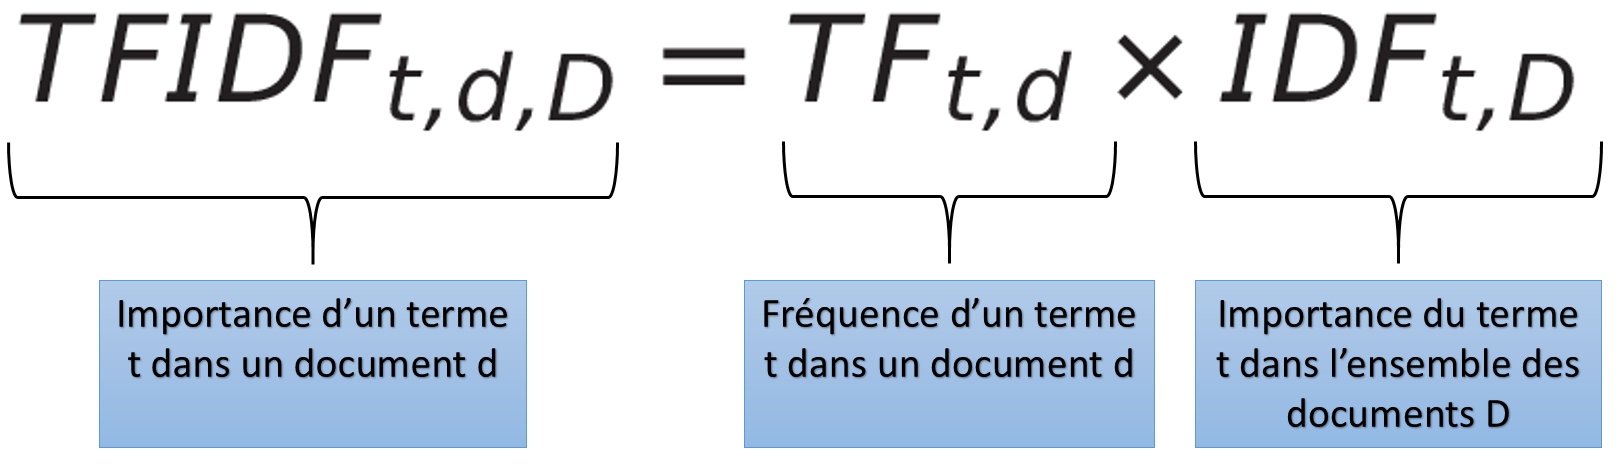

A noter qu'encore une fois, TF-IDF possède des inconvénients car il ne permet pas de prendre en compte de l'ordre des mots au sein de la phrase.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(df['text_processed'])

X = vectorizer.transform(df['text_processed'])
df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
df_tfidf['airline_sentiment'] = df['airline_sentiment']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
df_tfidf.head()

,aa,aaaand,aaba,aacom,aacustomerservic,aadavantag,aadfw,aadv,aadvantag,aal,...,zigzag,zip,zipper,zone,zoom,zrhairport,zuke,zurich,zurichnew,airline_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


## 3) Doc2Vec

Doc2Vec permet de transformer un texte en un vecteur (dont on peut choisir la dimension), en essayant de prendre en compte l'ordre des mots. Cette méthode présente donc quelques avantages par rapport à Bag-of-words et TF-IDF.

La méthode est similaire à Word2Vec, qui essaye d'identifier les mots qui apparaissent souvent ensemble, afin d'en déduire ensuite une représentation vectorielle de chacun des mots. Le but étant ensuite que les mots ayant un sens similaire possèdent des vecteurs proches. (Voir par exemple l'image ci-dessous)

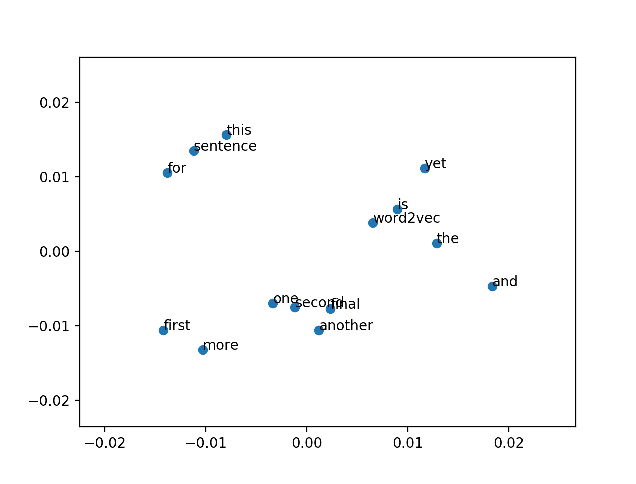

In [14]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [15]:
tokenized_text = []
n = len(df)
for i in range(n):
    tokenized_text.append(word_tokenize(df['text_processed'][i]))

In [16]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

In [17]:
X = []
for i in range(n):
    X.append(model.infer_vector(tokenized_text[i]))
             
df_d2v = pd.DataFrame(X)
df_d2v['airline_sentiment'] = df['airline_sentiment']
df_d2v.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,airline_sentiment
0,0.000193,-0.001577,0.002135,-0.007386,-0.010691,0.006945,-0.002961,-0.000522,0.001885,0.004593,...,-0.002729,0.004906,0.006442,0.000665,-0.004505,0.020765,-0.002223,-0.008388,0.003757,0
1,-0.004978,0.008744,-0.006873,-0.010935,-0.024715,0.022745,0.004473,0.005570,0.009340,-0.001215,...,-0.004556,0.005751,0.006139,0.010367,-0.009854,0.029679,-0.004991,-0.008211,0.001174,1
2,0.001810,-0.002013,-0.004389,0.001366,-0.008937,0.009887,0.002673,0.000673,-0.001421,0.001819,...,0.002415,0.001747,0.000312,0.006884,-0.004737,0.010508,-0.007717,-0.000032,-0.004292,0
3,-0.020077,0.018827,-0.005194,-0.025218,-0.057046,0.064086,-0.001556,0.005753,0.030141,-0.001907,...,-0.000151,0.007402,0.033105,0.027872,-0.044827,0.080577,-0.020022,-0.012841,-0.010382,-1
4,0.000664,0.004616,0.000845,-0.004822,-0.000282,0.000777,0.004352,-0.003811,-0.000134,0.004789,...,0.004083,-0.002220,-0.004160,0.005577,-0.004011,0.003448,-0.003368,-0.004002,0.003309,-1


# III) Entrainement d'un modèle

Dans cette partie, nous allons créer des modèles de machine learning simples avec scikit-learn (arbre de décision, random forests...) qui fournissent des résultats très corrects, et nous allons aussi implémenter des réseaux de neurones avec tensorflow pour s'initier au deep learning.

Ici, vous devez avoir transformé les textes du dataset en vecteurs.
Vous devez alors disposer d'une variable X contenant la liste de tous ces vecteurs, et d'une variable y contenant la liste des labels correspondants. Vous pouvez par ailleurs séparer ces données en données d'entrainement (qui serviront à entrainer le modèle) et en données de test (pour tester le modèle par la suite)

Avec ceci, vous pouvez initialiser un modèle, l'entrainer, puis le tester.

Pour l'instant, je ne vais utiliser que Bag-of-words comme représentation de données (mais vous pouvez également tester les modèles avec TF-IDF ou Doc2Vec)

In [18]:
import numpy as np

y = df['airline_sentiment']

X_bow = df_bow.drop(columns=['airline_sentiment'])
X_bow = np.asarray(X_bow)

# On sépare également nos données en données d'entrainement et de test
from sklearn.model_selection import train_test_split
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

## 1) Modèles de machine learning avec scikit-learn 

Si vous voulez savoir comment fonctionnent les algorithmes que nous allons utiliser ci-dessous, je vous redirige vers cette playlist : https://www.youtube.com/watch?v=NUXdtN1W1FE&list=PLEiEAq2VkUULNa6MHQAZSOBxzB6HHFXj4

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train_bow, y_train)

preds = model.predict(X_test_bow)
print("Accuracy : ", accuracy_score(preds, y_test))

Accuracy :  0.7144808743169399


In [ ]:
model = RandomForestClassifier(n_estimators=20)
model.fit(X_train_bow, y_train)

preds = model.predict(X_test_bow)
print("Accuracy : ", accuracy_score(preds, y_test))

Accuracy :  0.7633196721311475


In [ ]:
model = SGDClassifier()
model.fit(X_train_bow, y_train)

preds = model.predict(X_test_bow)
print("Accuracy : ", accuracy_score(preds, y_test))

Accuracy :  0.6523224043715847


In [ ]:
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train_bow, y_train)

preds = model.predict(X_test_bow)
print("Accuracy : ", accuracy_score(preds, y_test))

Accuracy :  0.6198770491803278


In [ ]:
model = SVC()
model.fit(X_train_bow, y_train)

preds = model.predict(X_test_bow)
print("Accuracy : ", accuracy_score(preds, y_test))

## 2) Modèle de deep learning : réseau de neurones (avec tensorflow)

Cette partie n'est pas du tout nécessaire, c'est seulement un approfondissement pour s'initier aux réseaux de neurones et à tensorflow. Il n'est même pas sûr que nos résultats soient meilleurs que ceux obtenus avec scikit-learn.

#### **Explication rapide du fonctionnement d'un réseau de neurones**

Voici le lien d'une vidéo si vous voulez une introduction au multi-perceptron (réseau de neurones le plus basique) : https://www.youtube.com/watch?v=1uH5p1zqXco

Pour faire une explication rapide, voici le fonctionnement d'un seul neurone :

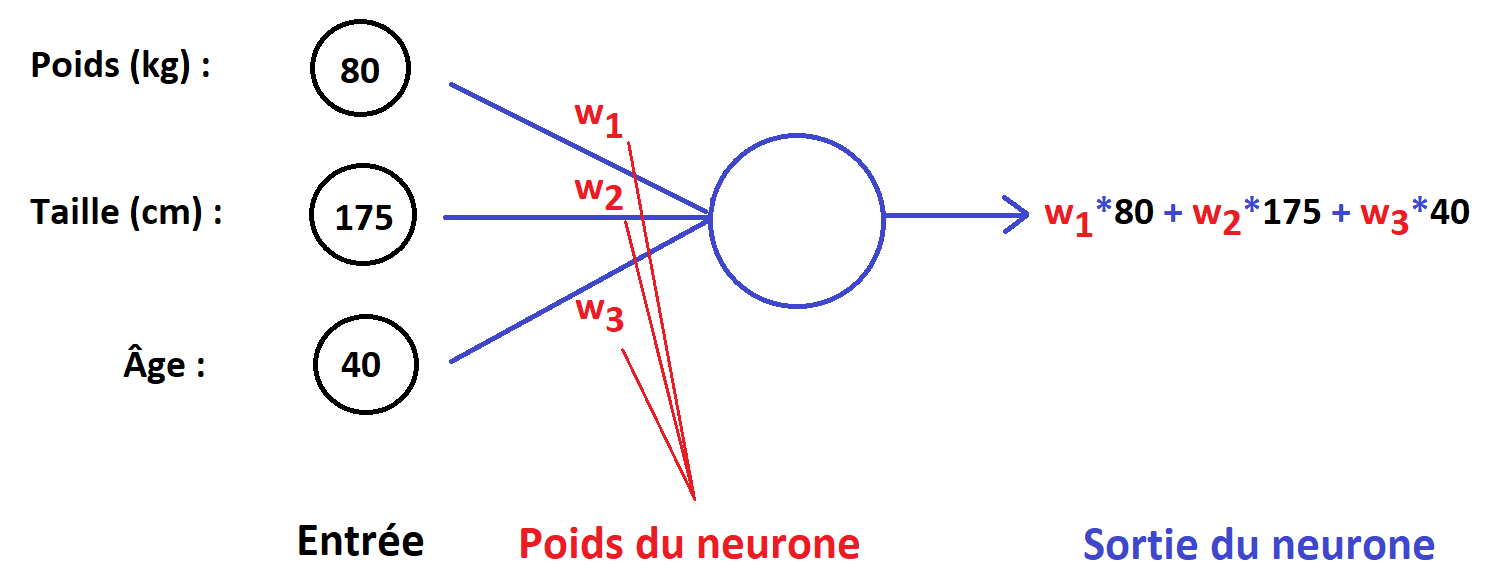

Comme sur la photo, le neurone possède des poids (qui sont des nombres), et il les combine avec les entrées afin de fournir une valeur en sortie. Un neurone prend donc valeurs en entrée, effectue des calculs avec (des produits grâce à ses poids puis une somme), et renvoie une nouvelle valeur. 

Comme le neurone renvoie une valeur, on peut très bien donner celle-ci à un deuxième neurone (qui possèderait aussi ses propres poids), et ainsi de suite. C'est exactement le fonctionnement d'un réseau de neurones : on empile des couches de neurones et on récupère la dernière valeur de celui-ci (voir image ci-dessous)

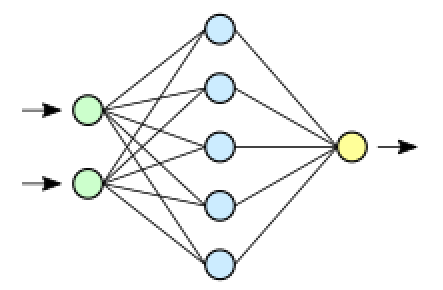

Ici, le réseau de neurones possède un seul neurone sur la dernière couche, cela signifie que le réseau ne renverra qu'une seule valeur. On pourrait mettre plusieurs neurones sur la dernière couche, et la sortie du réseau serait alors constituée de plusieurs valeurs.

Ensuite, en fonction de nos données et de ce que l'on attend comme valeur de sortie du réseau de neurones, celui-ci va "apprendre" les bonnes valeurs pour chaque poids de chacun de ses neurones.

J'ai volontairement passé sous silence des détails comme notamment la fonction d'activation (fonction que l'on peut appliquer à la sortie d'un neurone), ou le biais d'un neurone (constante que l'on ajoute à la somme que le neurone calcule). Si vous voulez plus de détails, je vous redirige vers la vidéo que j'ai conseillée un peu plus haut (https://www.youtube.com/watch?v=1uH5p1zqXco)

#### **Petite précision quant à la sortie du réseau de neurones**

Dans notre cas, on aimerait que le réseau de neurones nous renvoie trois valeurs (plutôt qu'une).

En effet, plutôt que de le faire renvoyer un nombre compris entre -1 et 1 qui représenterait le label, on va le faire renvoyer un vecteur de taille 3, où chaque composante indique la probabilité d'appartenir à chacune des classes (-1, 0 et 1).

Par exemple, si la sortie du modèle est [0, 0.1, 0.9], cela signifie que selon lui l'entrée appartient à la classe 0 (phrase neutre) avec une probabilité 10%, et à la classe 1 (phrase positive) avec une probabilité 90%.

Ainsi lors de l'entrainement, plutôt que de chercher à prédire le label 1 (phrase positive), nous allons plutôt essayer de prédire [0,0,1] : la probabilité de faire partie de la classe -1 ou 0 est nulle, alors que la probabilité de faire partie de la classe 1 est 1.

Il y a globalement deux raisons pour lesquelles on renvoie des "taux de confiance" ou des probabilités d'appartenance à chacune des classes, plutôt qu'une seule valeur représentant la classe :
- déjà, cela nous permet de savoir à quel point le modèle est sûr de lui lors d'une prédiction
- et surtout, le fait de vouloir que le modèle ne renvoie qu'une seule valeur peut créer une hiérarchie entre nos classes si le modèle qu'il renvoie 0 au lieu de 1 (erreur de 1), c'est moins grave que s'il avait renvoyé -1 au lieu de 1 (erreur de 2). Pour éviter de créer une telle hiérarchie qui n'aurait pas forcément de sens, on préfère renvoyer trois valeurs bien distinctes

Pour faire cela simplement d'un point de vue implémentation, on utilise la fonction "to_categorical". Léger détail : to_categorical nécessite que les labels soient positifs, donc je vais transformer les -1 en 2

#### **Retour au code**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# On modifie la forme des labels
from tensorflow.keras.utils import to_categorical

def change_labels(y):
    y = y.reset_index(drop=True)
    n = len(y)
    for i in range(n):
        if y[i] == -1:
            y[i] = 2
    return y

y2 = change_labels(y)
y_train2 = change_labels(y_train)
y_test2 = change_labels(y_test)

In [22]:
y_categ = to_categorical(y2)
y_train_categ = to_categorical(y_train2)

In [23]:
y_test_categ = to_categorical(y_test2)

La dernière couche du modèle que l'on va créer doit posséder 3 neurones et une activation softmax, afin que le réseau donne en sortie les probabilités d'appartenir à chacune des 3 classes.

In [ ]:
model = keras.Sequential()
model.add(tf.keras.Input(shape=(X_bow.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

On vient de créer un réseau de neurones à 4 couches :
- la première possède 64 neurones
- la deuxième en possède 32
- la troisième en possède 16
- et la dernière en possède 3, ainsi que softmax comme fonction d'activation

La cellule ci-dessous va permettre d'entrainer le modèle. Il va apprendre à diminuer la valeur de sa "loss" (son erreur), c'est-à-dire en gros apprendre à coller à nos données. Le terme "epochs=40" indique que le modèle va s'entrainer entièrement sur notre dataset 40 fois successivement, en espérant s'améliorer à chaque entrainement (la loss (erreur) devrait diminuer au fil des epochs).

In [ ]:
model.fit(X_train_bow, y_train_categ, validation_split=0.2, batch_size=64, epochs=40)

Epoch 1/40
147/147 [==============================] - 5s 10ms/step - loss: 0.7346 - accuracy: 0.6858 - val_loss: 0.5632 - val_accuracy: 0.7798
Epoch 2/40
147/147 [==============================] - 1s 8ms/step - loss: 0.4161 - accuracy: 0.8450 - val_loss: 0.5654 - val_accuracy: 0.7772
Epoch 3/40
147/147 [==============================] - 1s 8ms/step - loss: 0.2608 - accuracy: 0.9067 - val_loss: 0.6383 - val_accuracy: 0.7653
Epoch 4/40
147/147 [==============================] - 1s 7ms/step - loss: 0.1686 - accuracy: 0.9441 - val_loss: 0.7571 - val_accuracy: 0.7559
Epoch 5/40
147/147 [==============================] - 1s 7ms/step - loss: 0.1098 - accuracy: 0.9646 - val_loss: 0.8543 - val_accuracy: 0.7512
Epoch 6/40
147/147 [==============================] - 1s 7ms/step - loss: 0.0728 - accuracy: 0.9771 - val_loss: 0.9808 - val_accuracy: 0.7529
Epoch 7/40
147/147 [==============================] - 1s 7ms/step - loss: 0.0489 - accuracy: 0.9850 - val_loss: 1.0875 - val_accuracy: 0.7443
Epoch

Comme espéré, l'erreur (la loss) du modèle a diminué au fil des epochs, et son taux de précision (accuracy) a augmenté.

In [ ]:
def score(model, X, y):
    """
    Une fonction qui prend en argument un modèle, des données et les labels correspondants, et qui renvoie l'accuracy
    Ces étapes sont nécessaires car notre modèle renvoie un vecteur de probabilités du type [0,0,1] ou [0.1, 0.1, 0.8],
    avec les probabilités d'appartenir à chacune de nos trois classes.
    Pour savoir quelle classe a été prédie, il faut donc prendre celle qui a la plus grande probabilité.
    Pour cela, on utilise la fonction np.argmax de numpy
    """
    preds = model.predict(X)
    res = []
    n = len(preds)
    for i in range(n):
        res.append(np.argmax(preds[i]))

    return accuracy_score(res, y)

In [ ]:
score(model, X_test_bow, y_test2)

0.7448770491803278